**Testing the AD implementation**

In [3]:
import numpy as np

def construct_envelope(hull_points, h, domain):
    x_min, x_max = domain
    h_values = h(hull_points)

    slopes = np.gradient(h_values, hull_points)
    intercepts = h_values - hull_points * slopes

    z_points = [x_min]
    for i in range(len(hull_points) - 1):
        slope1, intercept1 = slopes[i], intercepts[i]
        slope2, intercept2 = slopes[i + 1], intercepts[i + 1]

        if np.abs(slope1 - slope2) < 1e-10:  # Avoid numerical instability
            raise ValueError("Consecutive slopes are too close; invalid envelope.")
        z_intersect = (intercept2 - intercept1) / (slope1 - slope2)
        z_points.append(z_intersect)

    z_points.append(x_max)
    pieces = [(float(slopes[i]), float(intercepts[i])) for i in range(len(slopes))]
    return pieces, z_points

def sample_piecewise_linear(pieces, z_points):
    # Input checks
    if len(z_points) != len(pieces) + 1:
        raise ValueError(f"Length of `z_points` ({len(z_points)}) should be length of `pieces` ({len(pieces)}) + 1")

    areas, cumulative_areas = [], [0]
    
    for i, (slope, intercept) in enumerate(pieces):
        x_start, x_end = z_points[i], z_points[i + 1]
        if slope == 0:
            area = np.exp(intercept) * (x_end - x_start)
        else:
            # Overflow protection
            log_start = intercept + slope * x_start
            log_end = intercept + slope * x_end
            log_start, log_end = check_overflow_underflow([log_start, log_end])
            area = (np.exp(log_end) - np.exp(log_start)) / slope
        areas.append(area)
        cumulative_areas.append(cumulative_areas[-1] + area)

    total_area = cumulative_areas[-1]
    u = np.random.uniform(0, total_area)
    segment = np.searchsorted(cumulative_areas, u) - 1
    slope, intercept = pieces[segment]
    x_start, x_end = z_points[segment], z_points[segment + 1]

    if slope == 0:
        return np.random.uniform(x_start, x_end)
    else:
        cdf_start = np.exp(np.clip(intercept + slope * x_start, -700, 700)) / slope
        cdf_sample = cdf_start + u - cumulative_areas[segment]
        return (np.log(cdf_sample * slope) - intercept) / slope

def calculate_envelope(x, pieces, z_points):
    
    for i in range(len(pieces)):
        if z_points[i] <= x <= z_points[i + 1]:
            slope, intercept = pieces[i]
            return intercept + slope * x


"""Superseded with version below, that updates envelope incrementally
def update_envelope(hull_points, new_point, h, domain):
    hull_points = np.sort(np.append(hull_points, new_point))
    return construct_envelope(hull_points, h, domain)
"""

def update_envelope(x_points, new_point, h, slopes, intercepts, z_points, domain):
    # Insert the new point into the sorted list of x_points
    x_points = np.sort(np.append(x_points, new_point))

    # Update slopes and intercepts based on the new point
    slopes = []
    intercepts = []
    for idx in range(1, len(x_points)):
        slopes.append((h(x_points[idx]) - h(x_points[idx - 1])) / (x_points[idx] - x_points[idx - 1]))
        intercepts.append(h(x_points[idx]) - slopes[-1] * x_points[idx])

    # Update z_points to reflect the new x_points and corresponding function values
    z_points = np.array([h(x) for x in x_points])  # This ensures z_points has length len(x_points)

    # Ensure the lengths of pieces and z_points are aligned
    pieces = list(zip(slopes, intercepts))

    # Print debug info for checking
    print(f"DEBUG: Updated Envelope - z_points length: {len(z_points)}, pieces length: {len(pieces)}")

    return x_points, slopes, intercepts, z_points
    
def adaptive_search_domain(f, start=0, step=1, threshold=1e-15, max_steps=int(1e7)):
    """
    Search the domain of the given function.
    
    Args:
    - f(function): Given function we want to search for domain of. 
    - start(float): Starting searching point.
    - step(float): Searching step.
    - threshold(float): Threshold to judge whether the function value is too small
    - max_steps(int): maximum searching steps.
    
    Returns:
    - domain_start, domain_end(float): The searching domain of the function.
    """
    
    x = start
    domain_points = []
    
    # Searching towards the positive side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        x += step
    
    x = start
    
    # Searching towards the negative side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        else:
            break
        x -= step
    
    if not domain_points:
        return None
    return min(domain_points), max(domain_points)

def init_points(f, domain, threshold = 1e-5):
    """
    Search the initial point of the .
    
    Args:
    - f(function): Given function. 
    - domain(tuple): domain of the function.
    - threshold(float): Threshold to judge whether to be the initial point.
    
    Returns:
    - init_1, init_2(tuple): Two initial points.
    """
    
    domain_min, domain_max = adaptive_search_domain(f)
    step = (domain_max - domain_min) / 1000
    
    init_1 = domain_min
    while f(init_1) <= threshold:
        init_1 += step
    
    init_2 = domain_max
    while f(init_2) <= threshold:
        init_2 -= step
        
    return init_1, init_2

def ars(f, num_samples, domain, burn_in=1000, num_init_points=10):
    """
    Adaptive Rejection Sampling with intelligent initialization and overflow protection.

    Args:
        f (function): Target probability density function.
        num_samples (int): Number of samples to generate.
        domain (tuple): Range of the distribution.
        burn_in (int): Number of initial samples to discard.
        num_init_points (int): Number of initial points for constructing envelope.

    Returns:
        np.array: Array of sampled points.
    """
    print("Starting ARS ...")
    print("Checking if the function is log-concave ...")
    if not is_log_concave(f, np.linspace(*domain, 1000)):
        raise ValueError("The input function is not log-concave!")

    h = lambda x: h_log(f, x)
    
    domain = adaptive_search_domain(f)
    init_1, init_2 = init_points(f, domain)
    x_points = np.linspace(init_1, init_2, num_init_points)
    
    samples = []
    pieces, z_points = construct_envelope(x_points, h, domain)
    slopes, intercepts = zip(*pieces)

    for i in range(num_samples + burn_in):
        # Sample from the envelope
        x_star = sample_piecewise_linear(pieces, z_points)
        u = np.random.uniform()
        print(f"DEBUG: Iteration {i}, x_star={x_star}, u={u}")

        # Check acceptance criteria
        if u <= np.exp(h_cached(f, x_star) - calculate_envelope(x_star, pieces, z_points)):
            print(f"DEBUG:      Accepted x_star={x_star}")
            if i >= burn_in:  # Only append after burn-in
                samples.append(x_star)
        else:
            print(f"DEBUG: Rejected x_star={x_star}")
            slopes = list(slopes)  # Convert slopes to list (if tuple)
            intercepts = list(intercepts)  # Convert intercepts to list (if tuple)
            z_points = list(z_points)

            # Incrementally update the envelope with the new point
            x_points, slopes, intercepts, z_points = update_envelope(
                x_points, x_star, h, slopes, intercepts, z_points, domain
            )
            pieces = list(zip(slopes, intercepts))

    print(f"Finished sampling. Total samples collected: {len(samples)}")
    return np.array(samples)

import numpy as np

def is_log_concave(f, x_range, eps=1e-10):
    """Checks if a function is log-concave over the given range."""
    x = np.asarray(x_range)
    
    if np.any(np.diff(x) <= 0): # Ensure no duplicates in range (for numerical differentiation)
        raise ValueError("x_range need to be increasing.")
    
    f_values = f(x)
    if np.any(f_values <= 0):
        raise ValueError("Function values must be positive.")
    
    f_values = np.maximum(f_values, eps)
    #f_prime = np.gradient(f_values, x)
    #log_deriv = f_prime / f_values
    #is_descending = np.all(np.diff(log_deriv) <= 0)
    
    log_f_values = np.log(f_values)
    
    # Compute second derivative
    log_f_second_derivative = np.gradient(np.gradient(log_f_values, x), x)
    
    # Check second derivative is non-positive (i.e. log-concave condition)
    is_log_concave = np.all(log_f_second_derivative <= 0)
    
    return is_log_concave

import numpy as np

def check_overflow_underflow(values, dtype=np.float64):
    """Checks if values are at risk of overflow/underflow, and clip them."""
    min_value = np.finfo(dtype).tiny  # Smallest positive number representable in the dtype
    max_value = np.finfo(dtype).max   # Largest number representable in the dtype
    
    values = np.clip(values, min_value, max_value)

    return values

def h_log(f, x):
    """Manual caching for log of the target function with underflow protection."""
    if isinstance(x, np.ndarray):
        x_key = tuple(x.tolist())  # Convert array to hashable tuple
    else:
        x_key = x

    if x_key not in h_log.cache:
        f_value = f(x)
        f_value = check_overflow_underflow(f_value)
        if isinstance(f_value, np.ndarray):
            f_value = np.maximum(f_value, np.finfo(float).eps)  # Prevent underflow for arrays
        else:
            f_value = max(f_value, np.finfo(float).eps)  # Prevent underflow for scalars
        h_log.cache[x_key] = np.log(f_value)

    return h_log.cache[x_key]

h_log.cache = {}

h_cache = {}

def h_cached(f, x):
    """Cache h values to avoid recomputing for the same x values."""
    if x not in h_cache:
        h_cache[x] = h_log(f, x)
    return h_cache[x]

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def compare_samples_to_distribution(samples, target_pdf, domain, check_mean=True):
    """
    Compare ARS-generated samples to the target distribution.

    Args:
        samples (np.ndarray): Samples generated by ARS.
        target_pdf (function): The target probability density function.
        domain (tuple): Domain of the distribution as (min, max).
        check_mean (bool): Whether to include mean comparison in the hierarchy.

    Returns:
        None. (Plots and/or prints comparison results.)
    """
    try:
        # 1. Compare Means (if defined)
        if check_mean:
            theoretical_mean, success = integrate_mean(target_pdf, domain)
            if success:
                sample_mean = np.mean(samples)
                print(f"Theoretical Mean: {theoretical_mean:.4f}")
                print(f"Sample Mean: {sample_mean:.4f}")
                print(f"Difference in Means: {np.abs(theoretical_mean - sample_mean):.4f}")
                plt.figure()
                plt.bar(["Theoretical Mean", "Sample Mean"], [theoretical_mean, sample_mean], color=["red", "blue"])
                plt.title("Comparison of Means")
                plt.show()
                return  # If mean is calculable, stop here

    except Exception as e:
        print(f"Mean comparison skipped: {e}")

    try:
        # 2. Kolmogorov-Smirnov (KS) Test
        print("Performing KS Test...")
        empirical_cdf = lambda x: np.mean(samples <= x)
        ks_stat, ks_pvalue = stats.kstest(samples, empirical_cdf)
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")

        if ks_pvalue < 0.05:
            print("Warning: KS Test suggests samples differ significantly from target distribution.")
        else:
            print("KS Test suggests samples align well with target distribution.")

    except Exception as e:
        print(f"KS Test skipped: {e}")

    try:
        # 3. Quantile-Quantile (QQ) Plot
        print("Generating QQ Plot...")
        theoretical_quantiles = np.linspace(domain[0], domain[1], len(samples))
        sample_quantiles = np.quantile(samples, np.linspace(0, 1, len(samples)))

        plt.figure()
        plt.scatter(theoretical_quantiles, sample_quantiles, label="Empirical vs Theoretical")
        plt.plot(theoretical_quantiles, theoretical_quantiles, color="red", linestyle="--", label="Ideal Fit")
        plt.title("QQ Plot")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"QQ Plot skipped: {e}")

    try:
        # 4. KL Divergence
        print("Calculating KL Divergence...")
        sample_pdf_values = target_pdf(samples)
        sample_pdf_values = np.maximum(sample_pdf_values, 1e-10)  # Avoid division by zero
        kl_div = np.mean(np.log(sample_pdf_values) - np.log(stats.gaussian_kde(samples)(samples)))
        print(f"KL Divergence: {kl_div:.4f}")

    except Exception as e:
        print(f"KL Divergence skipped: {e}")

def integrate_mean(pdf, domain, num_points=1000):
    """
    Numerically integrate the mean of a target PDF.

    Args:
        pdf (function): Target probability density function.
        domain (tuple): Domain of the distribution as (min, max).
        num_points (int): Number of points for numerical integration.

    Returns:
        (mean, success) (float, bool): Theoretical mean and success status.
    """
    try:
        x_vals = np.linspace(*domain, num_points)
        pdf_values = pdf(x_vals)
        pdf_values = np.maximum(pdf_values, 1e-10)  # Avoid numerical issues
        mean = np.trapz(x_vals * pdf_values, x_vals) / np.trapz(pdf_values, x_vals)
        return mean, True
    except Exception as e:
        print(f"Error integrating mean: {e}")
        return None, False

Starting ARS ...
Checking if the function is log-concave ...
DEBUG: Iteration 0, x_star=0.06633110129605004, u=0.2010712921269674
DEBUG:      Accepted x_star=0.06633110129605004
DEBUG: Iteration 1, x_star=-0.9021460378988884, u=0.09903227831400263
DEBUG:      Accepted x_star=-0.9021460378988884
DEBUG: Iteration 2, x_star=-0.97781486590946, u=0.9372661247596025
DEBUG: Rejected x_star=-0.97781486590946
DEBUG: Updated Envelope - z_points length: 11, pieces length: 10
DEBUG: Iteration 3, x_star=-11.298564599675823, u=0.5960721638221653
DEBUG:      Accepted x_star=-11.298564599675823
DEBUG: Iteration 4, x_star=-11.221653616036056, u=0.7312274723716575
DEBUG:      Accepted x_star=-11.221653616036056
DEBUG: Iteration 5, x_star=-11.426677045606004, u=0.4581078733902094
DEBUG:      Accepted x_star=-11.426677045606004
DEBUG: Iteration 6, x_star=-11.15976245646014, u=0.8736563414020385
DEBUG:      Accepted x_star=-11.15976245646014
DEBUG: Iteration 7, x_star=-10.908677793417679, u=0.3587165789489

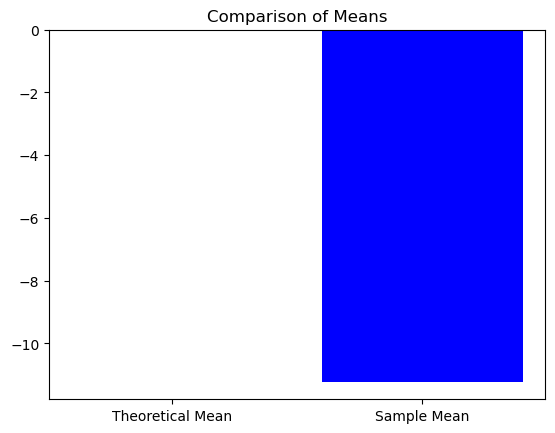

In [4]:
# Define a target PDF
def normal_pdf(x):
    return np.exp(-x**2 / 2)

# Generate samples using ARS
domain = (-5, 5)
samples = ars(normal_pdf, 1000, domain)

# Compare the samples with the target distribution
compare_samples_to_distribution(samples, normal_pdf, domain)